## Data analysis

This notebook shall be executed after step 2 of [Training_Drogate.ipynb](Training_Drogate.ipynb), which have some  common codes.

It does :

* Some stats on data set
* Try featuring labels
* Outliers detection and deletion


## 1. Import librairies and modules 

The following requirements shall be installed before import :

* OpenCV (recommanded : 4.0.0)
* Seaborn (recommanded : 0.9.0)
* ScikitLearn (recommanded : 0.20.3)

You will also need last versions of : numpy, pandas,  utils, json

In [60]:
import os
from utils import *
import numpy as np
import cv2
from matplotlib import pyplot as plt
import time

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from matplotlib import pyplot as plt
import matplotlib.patches as patches
import cv2
import seaborn as sns; sns.set()

from sklearn.cluster import KMeans
from random import choice
from random import sample
from numpy.linalg import norm


#Define local tree
data_path='data/' 
preprocessing_path="preprocessing/"
tmp_path="tmp/"
images_path=data_path+"images/"
labels_path=data_path+"labels/"
training_images_path=images_path+"Data_Training/"
np_training_labels=labels_path+"image_coordinates_dictionnary_v2.npy" 
outlier_labels=preprocessing_path+"outliers.npy"
tmp_labeled_images_path=tmp_path+"labeled_images/"

#Create local tree for Data Cleaning
def mkdir_exists(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

mkdir_exists(preprocessing_path)
mkdir_exists(tmp_labeled_images_path)

## 2. Saving labeled images

Labels (Gate Coordinates) are appended on images to distinguish labelisation error and saved in temp directory.
It may take time and required 2 GO.

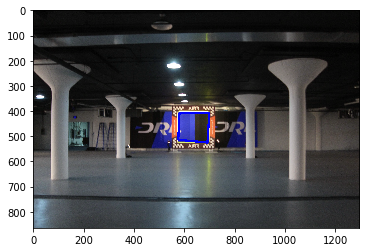

In [23]:
# Saving images with Labels in a specific directory
image_coordinate_dictionary = np.load(np_training_labels).item()
labels=[]

for i in range(len(image_coordinate_dictionary)):
    image_name=list(image_coordinate_dictionary.keys())[i]
    label = image_coordinate_dictionary[image_name]
    if len(label) != 0:
        labels.append(label)
        img = cv2.imread( training_images_path + image_name)
        pts = np.array([[label[0], label[1]], [label[2], label[3]], [label[4], label[5]], [label[6], label[7]]])
        thick = 8
        color = (0, 0, 255)
        cv2.line(img, tuple(pts[0]), tuple(pts[1]), color=color, thickness=thick, lineType=8, shift=0)
        cv2.line(img, tuple(pts[1]), tuple(pts[2]), color=color, thickness=thick, lineType=8, shift=0)
        cv2.line(img, tuple(pts[2]), tuple(pts[3]), color=color, thickness=thick, lineType=8, shift=0)
        cv2.line(img, tuple(pts[3]), tuple(pts[0]), color=color, thickness=thick, lineType=8, shift=0)
        cv2.imwrite(tmp_labeled_images_path + image_name, img)

# Show last labeled image
plt.imshow(img)
plt.show()

## 3. Define visualisation tools

We define visualisation tools on images to be able to answer questions like :

* Why my label isn't well predicted ?
* Which form does my gate get ?

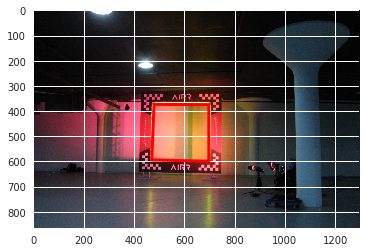

In [61]:
# Used functions
def image_name_from_number(image_number):
    return list(image_coordinate_dictionary.keys())[image_number]

def draw_label (image_number,label):
    image_name=image_name_from_number(image_number)
    label=image_coordinate_dictionary[image_name]
    img=cv2.imread(training_images_path + image_name)
    pts = np.array([[label[0],label[1]],[label[2],label[3]],[label[4],label[5]],[label[6],label[7]]])
    
    fig,ax = plt.subplots(1)
    ax.imshow(img)
    
    pol=patches.Polygon(pts,closed=True,fill=0,edgecolor='r',linewidth=3)

    ax.add_patch(pol)
    plt.ion()
    plt.show()

# Draw a label on image for example
draw_label(2,labels[2])

## 3. Descriptive Statistics

We choose Pair Plot in order to study depencies between labels coordinates

We observed  :
* a very high correlation of x1//x4 and x2//x3 
* a significant correlation between y4//y3 and y1//y2.
* Coordinates could be supposed normally distributed

We conclude that Gate is almost always vertical to the surface and correlations shall help us design the DroGate output layer and do post-processing.

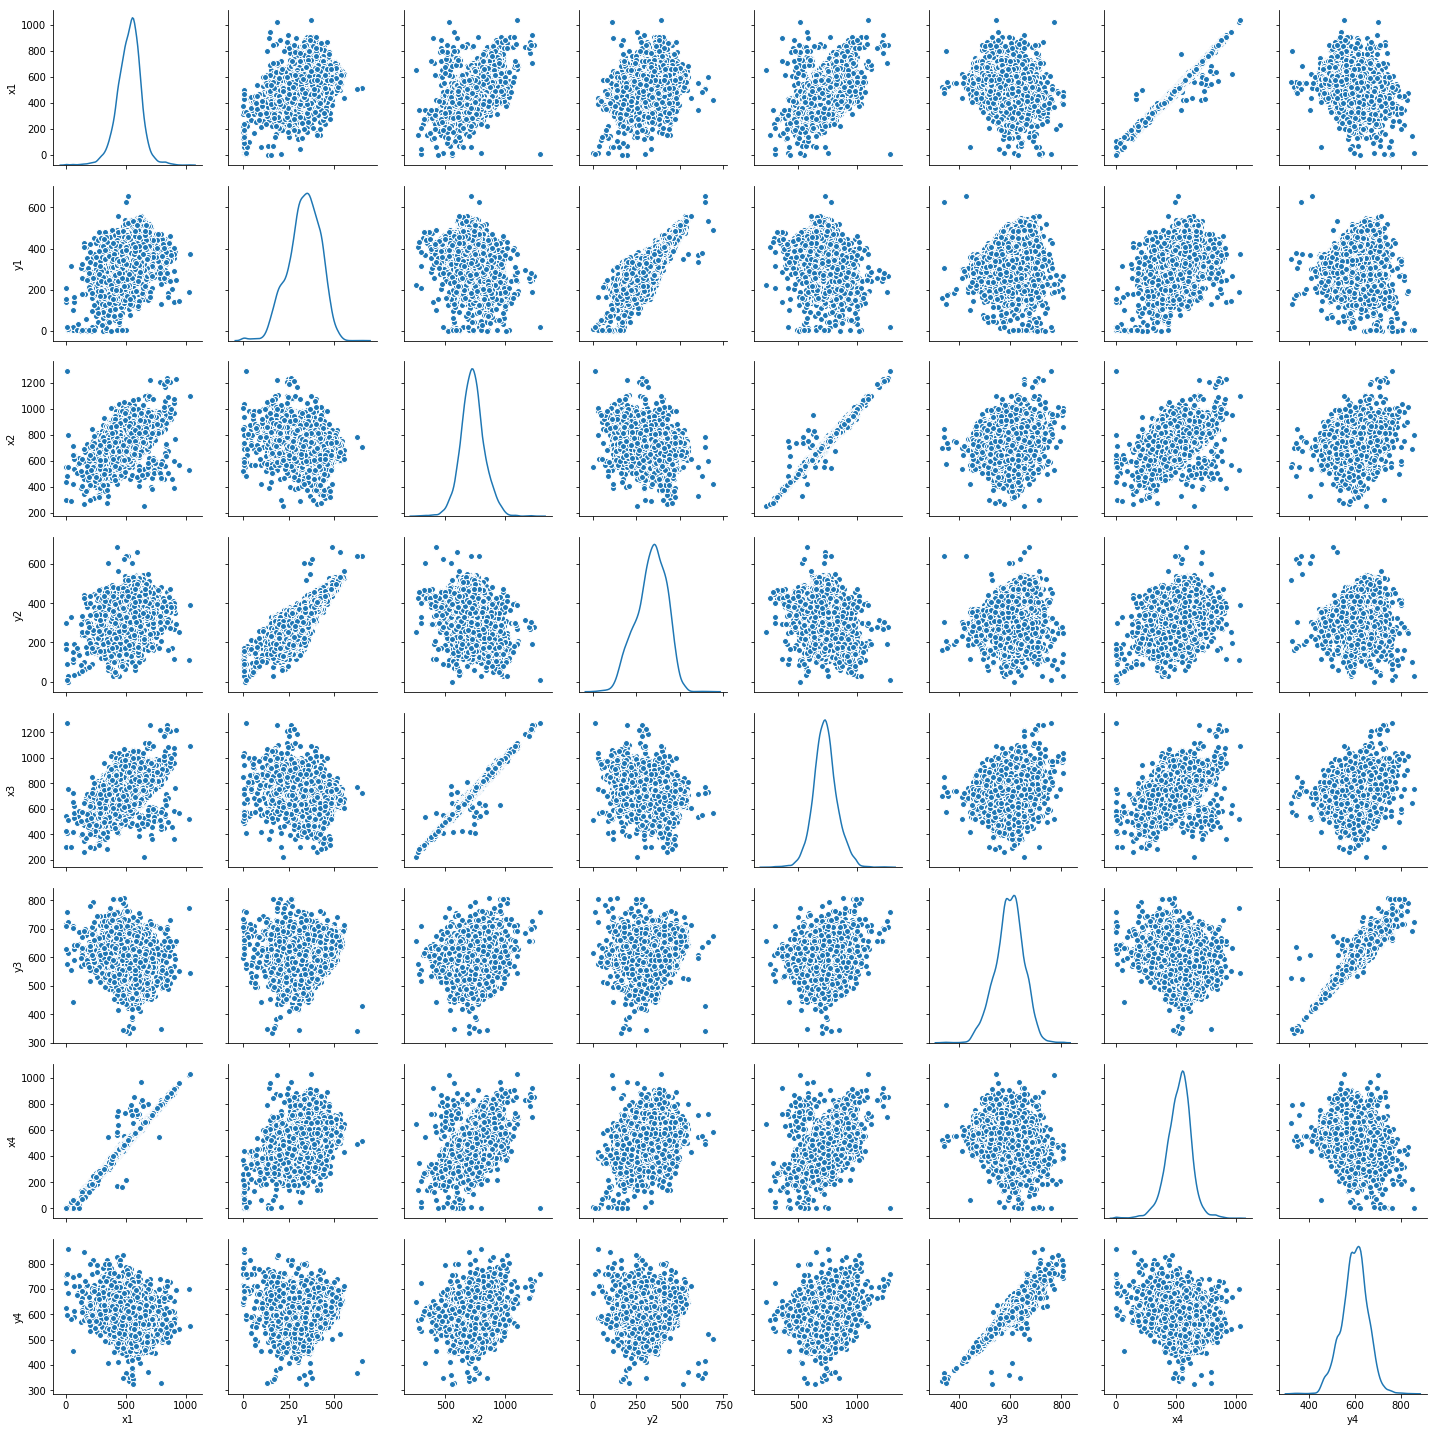

In [25]:

labels_df=pd.DataFrame(labels,columns=['x1','y1','x2','y2','x3','y3','x4','y4'])
sns.pairplot(labels_df.dropna(),diag_kind="kde")


# 4. The Trapeze hypothesis

Naming the gate with it's four coordinates A B C D, and knowing that the projection of the gate on the image
is "at least" a trapeze, we will look for images that are mislabeled based on this a priori knowledge.

We suppose :
ABCD trapez <==> AD // BC

/home/zeryab/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


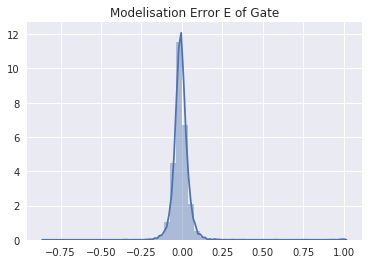

In [62]:

def err_collinearity (x):
    AD=np.array([x[0]-x[6],x[1]-x[7]])
    BC=np.array([x[2]-x[4],x[3]-x[5]])
    AD=AD/norm(AD)
    BC=BC/norm(BC)
    return AD[0]*BC[1]-AD[1]*BC[0]

# How far is this a trapeze ?
E=labels_df.apply(err_collinearity,axis=1)
E=E.dropna()
E=E.values

# Plotting distribution 
sns.distplot(E).set_title("Modelisation Error E of Gate")

# the absolute sorted values show clear outliers
#sns.scatterplot( range(len(E)) , np.sort(np.abs(E)) ).set_title('Absolute sorted values of E')


#Mark the 10% biggest value as we suppose E normaly distrubuted
D9=int(0.90*len(E))
thresh=np.sort(np.abs(E))[D9]
np.sort(np.abs(E))[D9:]
E_outliers=[i for i,j in enumerate(E) if np.abs(E[i]) > thresh]


#Visualize these outliers
#for o in (E_outliers):
#    draw_label(o,labels[o])


# 5. The Parallelogram hypothesis

In some ideal cases (far gates), their projection on the image plan is a parallelogram

/home/zeryab/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


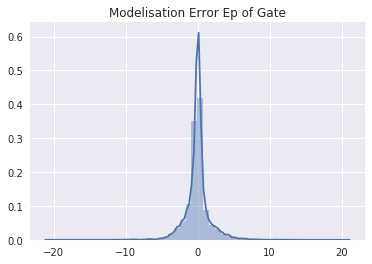

In [63]:

def parallelogram_identity(x):
    AB=x[0]-x[2],x[1]-x[3]
    BC=x[2]-x[4],x[3]-x[5]
    AC=x[0]-x[4],x[1]-x[5]
    BD=x[2]-x[6],x[3]-x[7]
    
    return (2*norm(AB)**2 + 2*norm(BC)**2 - norm(AC)**2 - norm(BD)**2)

E_prime=labels_df.apply(parallelogram_identity,axis=1)
E_prime=E_prime.dropna()
E_prime=E_prime.values
scaler=RobustScaler()
E_prime=scaler.fit_transform(E_prime.reshape((-1,1))).ravel()

# Plotting distribution 
sns.distplot(E_prime).set_title("Modelisation Error Ep of Gate")

# The absolute sorted values show clear outliers
#sns.scatterplot(range(len(E_prime)),np.sort(np.abs(E_prime))).set_title('Absolute sorted values of E_prime')

#Mark the 5% biggest value of absolute sorted values of E as outliers
D9=int(0.95*len(E_prime))
thresh=np.sort(np.abs(E_prime))[D9]
np.sort(np.abs(E_prime))[D9:]
E_prime_outliers=[i for i,j in enumerate(E_prime) if np.abs(E_prime[i]) > thresh]


#Visualize these outliers
#for o in E_prime_outliers:
#    draw_label(o,labels[o])


# 6. The Upper-part hypothesis

Some of the labels represent only the upper part of the gate, also some gates are labeled in the wrong order

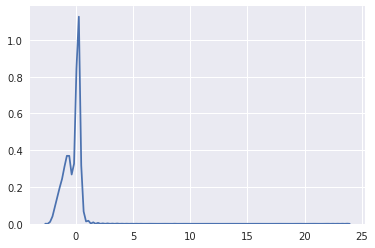

In [64]:

def rapport(x):
    AB=x[0]-x[2],x[1]-x[3]
    BC=x[2]-x[4],x[3]-x[5]
    AD=x[0]-x[6],x[1]-x[7]
    CD=x[4]-x[6],x[5]-x[7]
    
    return (max(norm(AB),norm(CD))/min(norm(BC),norm(AD)))

R=labels_df.apply(rapport,axis=1)
R=R.dropna()
R=R.values
scaler=RobustScaler()
R=scaler.fit_transform(R.reshape((-1,1))).ravel()

sns.kdeplot(R)

D9=int(0.98*len(R))
thresh=np.sort(np.abs(R))[D9]
np.sort(np.abs(R))[D9:]
R_outliers=[i for i,j in enumerate(R) if np.sort(np.abs(R))[i] >thresh]

# Visualize the results
#for o in R_outliers:
#    draw_label(o,labels[o])


In [91]:
# Saving outliers

outliers=np.append(np.array(E_outliers), np.array(E_prime_outliers))

np.save(outlier_labels, np.unique(outliers))



[   4    5    6 ... 9323 9330 9332]
